In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train_V2.csv', 'test_V2.csv', 'sample_submission_V2.csv']


# EDA

In [4]:
# library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

In [5]:
# optional suppression of warning
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [6]:
# data import
pubg_train = pd.read_csv('../input/train_V2.csv')
pubg_test = pd.read_csv('../input/test_V2.csv')

In [7]:

# check the train and test data are from the same distribution
# first trin
pubg_train_stats =  pubg_train.describe()
pubg_train_stats

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,2.299759e+01,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,5.097262e+01,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.132000e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [8]:
# then test
pubg_test_stats =  pubg_test.describe()
pubg_test_stats

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
count,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06,1.934174e+06
mean,2.299524e-01,1.104360e+00,1.297406e+02,6.541500e-01,2.258147e-01,1.357999e+00,4.781403e+01,5.094502e+02,9.183569e-01,5.435855e-01,2.283917e+01,1.576554e+03,4.488918e+01,4.340615e+01,8.873689e+02,1.630189e-01,5.909889e+02,3.408690e-03,4.505277e+00,2.335829e-02,7.680798e-03,1.149258e+03,3.627590e+00,6.113582e+02
std,5.785920e-01,1.713828e+00,1.674371e+02,1.133690e+00,5.933918e-01,2.665694e+00,2.746275e+01,6.288322e+02,1.523761e+00,7.090114e-01,5.057429e+01,2.566299e+02,2.387529e+01,2.329498e+01,7.378231e+02,4.682340e-01,1.474899e+03,7.298342e-02,3.026267e+01,1.650875e-01,9.149580e-02,1.179668e+03,2.359042e+00,7.406629e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.400000e+01,2.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.366000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.541000e+02,2.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,8.416000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.436000e+03,3.000000e+01,3.000000e+01,1.442000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.795000e+02,3.000000e+00,0.000000e+00
75%,0.000000e+00,2.000000e+00,1.854000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.175000e+03,1.000000e+00,1.000000e+00,2.120000e+01,1.849000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,6.300000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.970000e+03,5.000000e+00,1.495000e+03
max,2.700000e+01,2.400000e+01,6.229000e+03,5.900000e+01,4.100000e+01,7.500000e+01,1.000000e+02,2.174000e+03,5.800000e+01,1.500000e+01,1.004000e+03,2.217000e+03,1.000000e+02,1.000000e+02,5.742000e+03,2.000000e+01,4.070000e+04,1.500000e+01,3.271000e+03,9.000000e+00,5.000000e+00,1.491000e+04,1.530000e+02,2.000000e+03


In [9]:
# and finally subtract one from the other and crosscheck magnitures
pubg_train_stats.drop(columns = 'winPlacePerc')
train_test_difference = pubg_train_stats - pubg_test_stats
train_test_difference

,DBNOs,assists,boosts,damageDealt,headshotKills,heals,killPlace,killPoints,killStreaks,kills,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,winPoints
count,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,2.512792e+06,NaN,2.512792e+06
mean,3.725464e-03,3.862496e-03,2.547927e-03,9.765701e-01,1.004848e-03,1.214786e-02,-2.146769e-01,-4.444160e+00,3.696065e-04,6.426444e-03,1.584271e-01,2.952698e+00,-3.845063e-01,-3.985601e-01,4.641551e+00,1.640063e-03,1.512679e+01,8.740127e-05,4.045496e-03,5.101168e-04,2.374095e-04,4.959679e+00,3.289724e-02,NaN,-4.898097e+00
std,1.205238e-02,9.981116e-03,1.966034e-03,3.343522e+00,8.763491e-03,1.428773e-02,1.870684e-04,-1.327351e+00,1.960740e-03,3.468354e-02,3.983297e-01,2.109942e+00,-4.718762e-02,-5.489763e-03,-1.175304e+00,3.933130e-03,2.344486e+01,3.895464e-04,2.395263e-01,2.306047e-03,1.115764e-03,3.828866e+00,9.750155e-02,NaN,-9.624088e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.500000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e-02,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.100000e+00,0.000000e+00,NaN,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00,0.000000e+00,0.000000e+00,1.200000e-01,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.846750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,NaN,0.000000e+00
max,-6.000000e+00,-5.000000e+00,9.000000e+00,3.870000e+02,2.300000e+01,5.000000e+00,1.000000e+00,-4.000000e+00,5.000000e+00,1.400000e+01,9.000000e+01,2.000000e+01,0.000000e+00,0.000000e+00,1.680000e+02,1.900000e+01,1.000000e+01,3.000000e+00,5.520000e+02,3.000000e+00,0.000000e+00,1.087000e+04,8.300000e+01,NaN,1.300000e+01


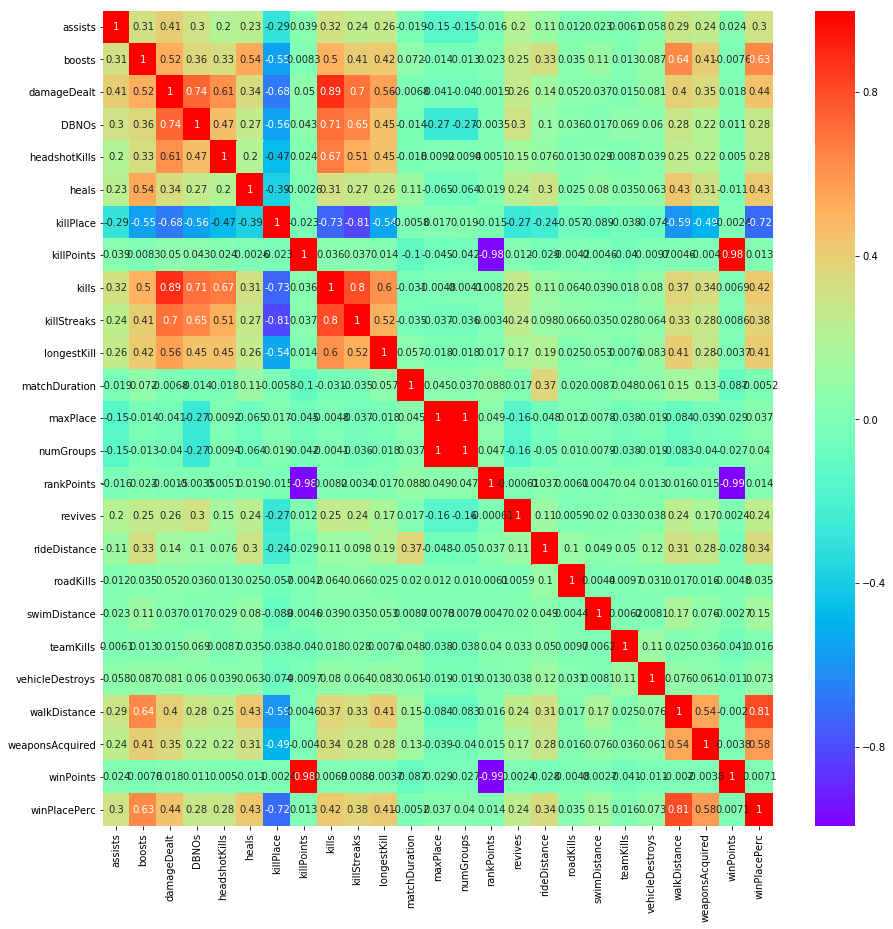

In [10]:
# lets start with a basic correlation plot
corr_vals = pubg_train.corr()

fig, axes = plt.subplots(figsize=(15,15))
sns.heatmap(corr_vals, ax = axes, cmap="rainbow", annot=True);

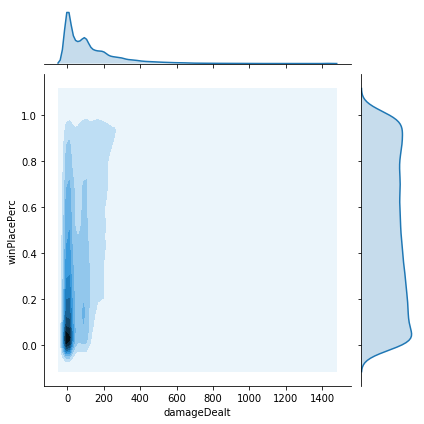

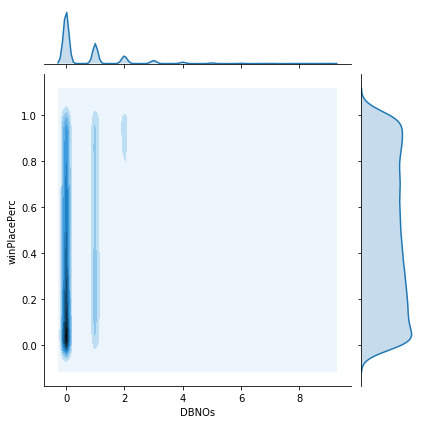

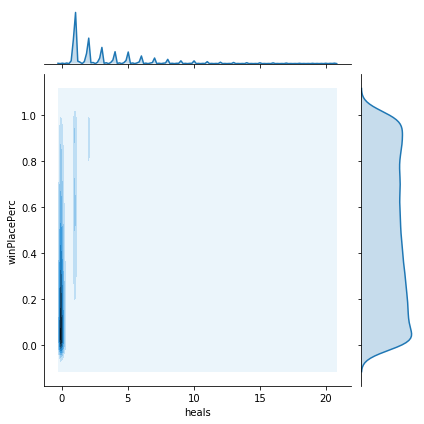

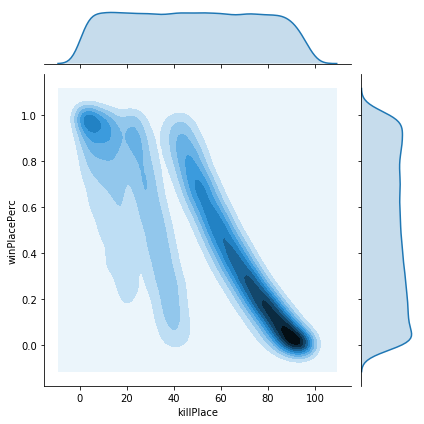

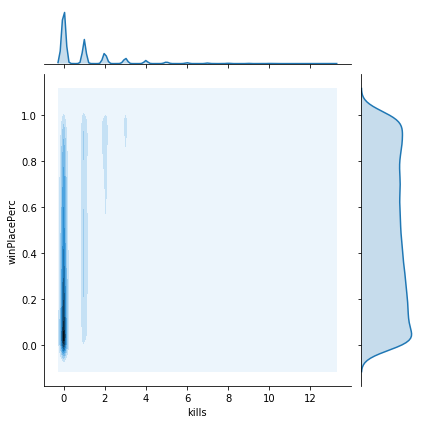

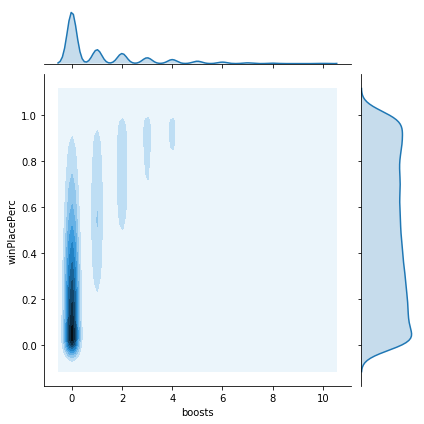

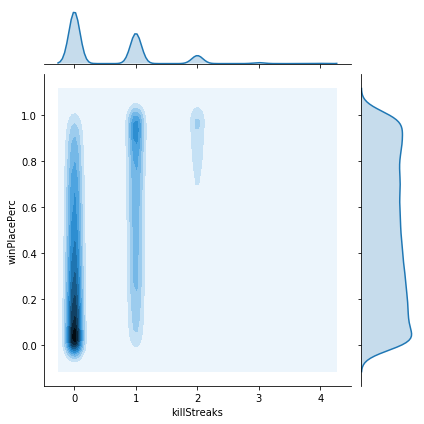

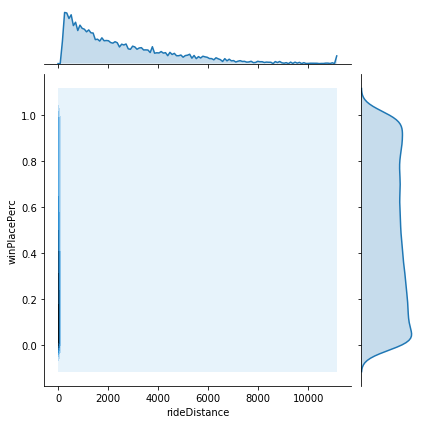

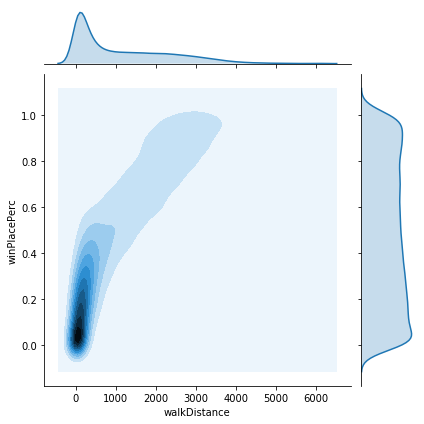

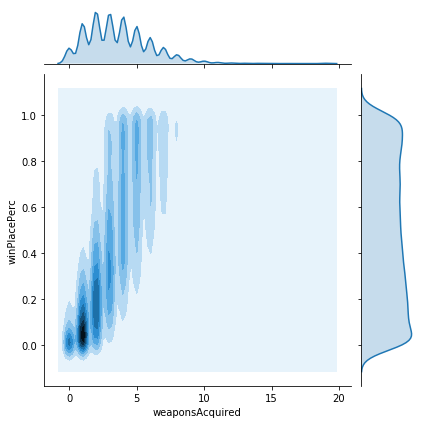

In [11]:
# lets see how each individual variable is related to the target variable
# note that to finish in a reasonable time we need to take a subset
# of the training data
pubg_small = pubg_train[0:-1:100]

# select interesting correlated columns
column_list = [
    'damageDealt', 'DBNOs', 'heals',
    'killPlace',  'kills', 'boosts',
    'killStreaks',  'rideDistance', 'walkDistance',
    'weaponsAcquired']
pubg_clipped = pubg_small[column_list+['winPlacePerc']]

# clip off extremes to get nice plots
pubg_clipped = pubg_clipped.clip(
    lower=None, upper= pubg_clipped.quantile(0.999), 
    axis = 1)

#ycle though columns to look at correlation
for column in column_list:
    #print(column)
    sns.jointplot(x = column, y = "winPlacePerc", data = pubg_clipped, kind = "kde")

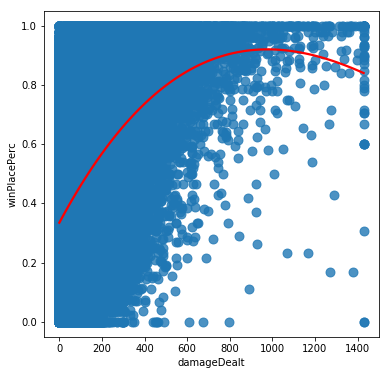

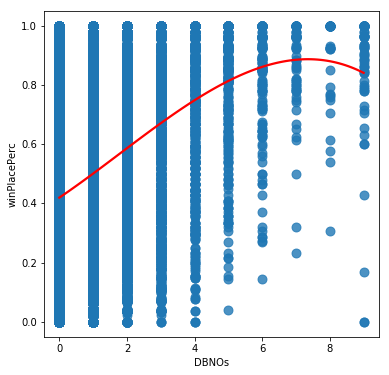

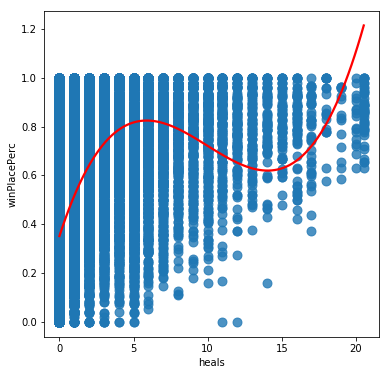

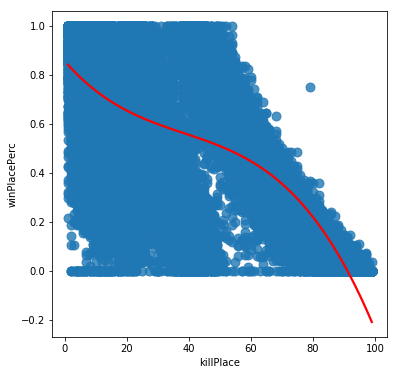

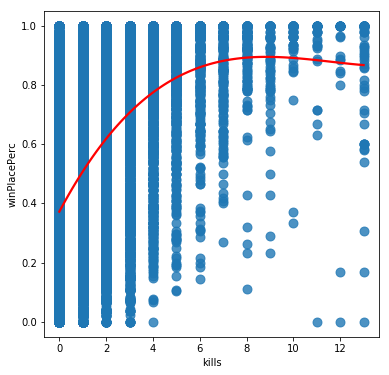

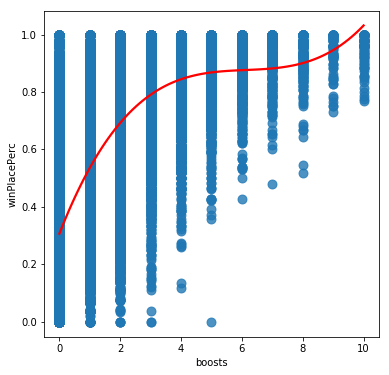

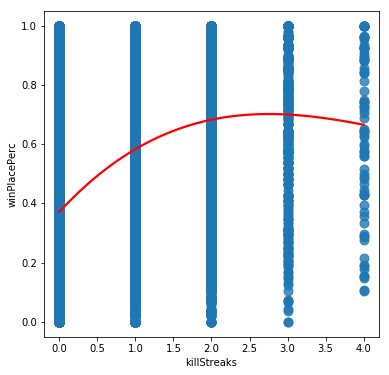

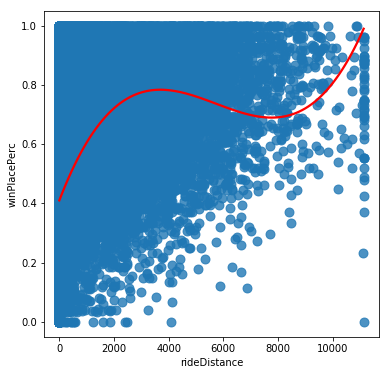

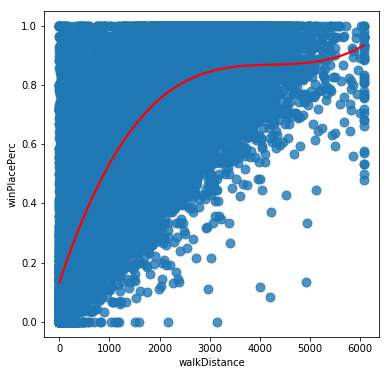

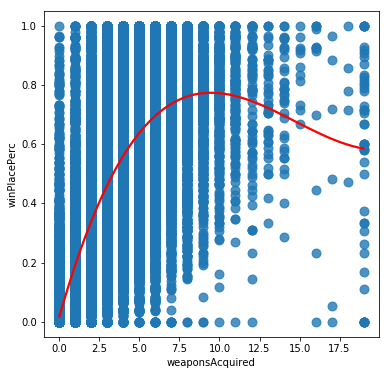

In [12]:
#cycle though columns to look at how linear the correlation is
for column in column_list:
    #print(column)
    fig, axes = plt.subplots(figsize=(6,6))
    ax = sns.regplot(x = column, y = "winPlacePerc", data = pubg_clipped,
        scatter_kws={"s": 80}, order=3, line_kws={'color':'red'},
        robust = False, ci=None, truncate=True)

In [13]:
# set up our feature engineering labels

# list of the variables suspected to be significant in data analysis
variables = ['killPlace', 'boosts', 'walkDistance', 'weaponsAcquired', 'damageDealt', 'heals', 
             'kills', 'longestKill', 'killStreaks', 'rideDistance','rampage', 'lethality', 
             'items', 'totalDistance']

keep_labels = variables + ['matchId','groupId', 'matchType', 'winPlacePerc']

def feature_engineering(pubg_data):
    '''FEATURE ENGINEERING
    GIVEN: a PUBG dataframe which must have a dummy 'winPlacePerc' column if a test set
    Conduct data engineering including:
    producing group data, normalising data with relevant match stats, clipping extreme results
    RETURNS: pubg_x dataframe consisting of feature engineered input columns
             pubg_y dataframe with target values (0 dummy frame if this is a test set)
    '''

    # total the pickups
    pubg_data['items'] = pubg_data['heals'] + pubg_data['boosts'] + pubg_data["weaponsAcquired"]
    
    # total the distance
    pubg_data['totalDistance'] = pubg_data['rideDistance'] + pubg_data['swimDistance'] + pubg_data['walkDistance']

    # estimate accuracy of players
    pubg_data['lethality'] = pubg_data['headshotKills'] / pubg_data['kills']
    pubg_data['lethality'].replace(np.inf, 0, inplace=True)
    pubg_data['lethality'].fillna(0, inplace=True)
    
    # estimate how players behave in shootouts
    pubg_data['rampage'] = pubg_data['killStreaks'] / pubg_data['kills']
    pubg_data['rampage'].replace(np.inf, 0, inplace=True)
    pubg_data['rampage'].fillna(0, inplace=True)
    
    # reduce dataframe to the columns we want to use
    pubg_data = pubg_data[keep_labels]

    # use groupby to get means for team
    pubg_group_means = pubg_data.groupby(['matchId','groupId']).mean().reset_index()

    # use groupby to get means of matches
    pubg_match_means = pubg_data.groupby(['matchId']).mean().reset_index()

    # merge back in leaving columns unchanged for one set to allow for future suffixing (only affects shared columns)
    pubg_engineered = pd.merge(pubg_data, pubg_group_means, 
                               suffixes=["", "_group"], how = "left", on = ['matchId', 'groupId']) 
    pubg_engineered = pd.merge(pubg_engineered, pubg_match_means, 
                               suffixes=["_player", "_match"], how = "left", on = ['matchId'])

    # norm the player variables
    for variable in variables:
        pubg_engineered[variable+'_norm'] = pubg_engineered[variable+'_player']/(pubg_engineered[variable+'_match']+0.1)

    # norm the group variables
    for variable in variables:
        pubg_engineered[variable+'_g_norm'] = pubg_engineered[variable+'_group']/(pubg_engineered[variable+'_match']+0.1)
        
    # one hot encode the matchTypes since different matches may follow different logics
    one_hot = pd.get_dummies(pubg_engineered['matchType'])
    # Drop column B as it is now encoded
    pubg_engineered = pubg_engineered.drop('matchType',axis = 1)
    # Join the encoded df
    pubg_engineered = pubg_engineered.join(one_hot)
    pubg_engineered.drop(columns = ['winPlacePerc_group', 'winPlacePerc_match'], inplace = True)
    pubg_engineered.rename(columns = {'winPlacePerc_player': 'winPlacePerc'}, inplace = True)
    pubg_engineered = pubg_engineered.reset_index(drop=True)
    
    return pubg_engineered

In [14]:
# must engineer on the full dataset to get correct group and match means
pubg_engineered = feature_engineering(pubg_train)
# group related cloumns together
pubg_engineered = pubg_engineered.sort_index(axis=1)

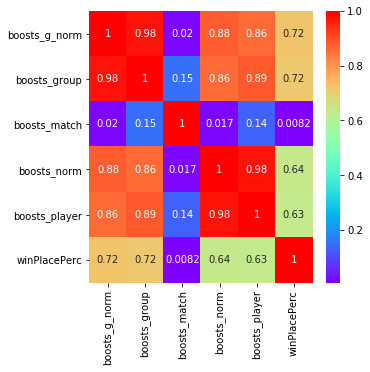

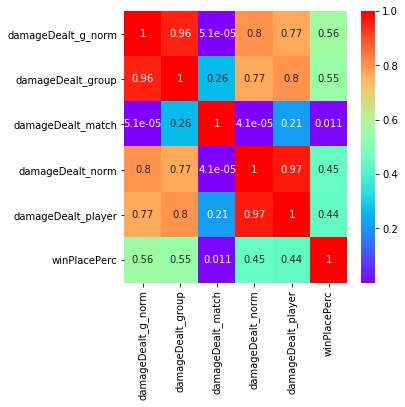

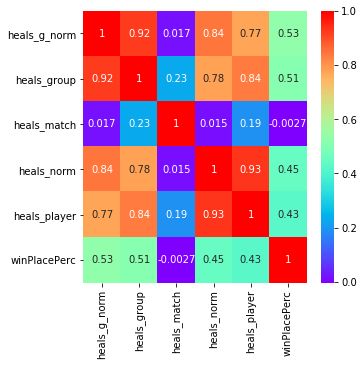

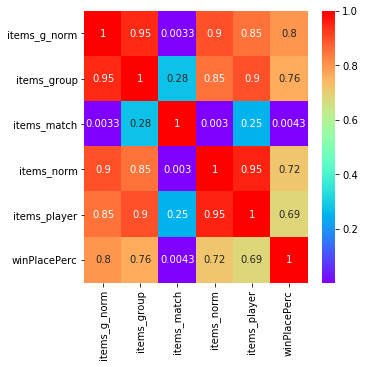

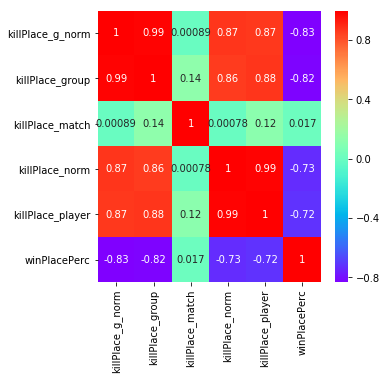

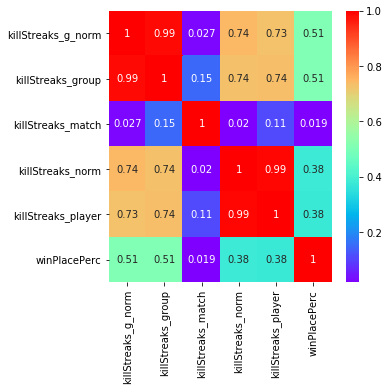

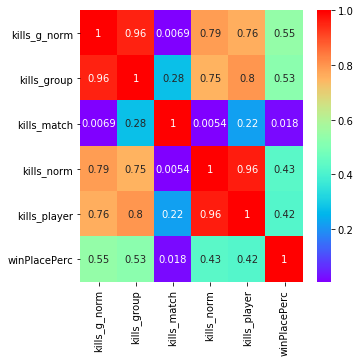

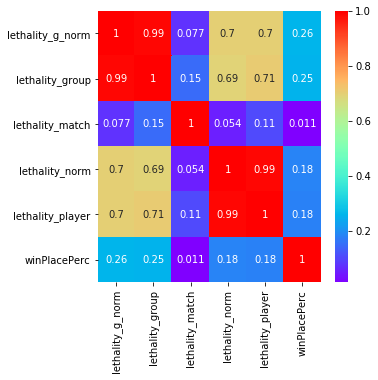

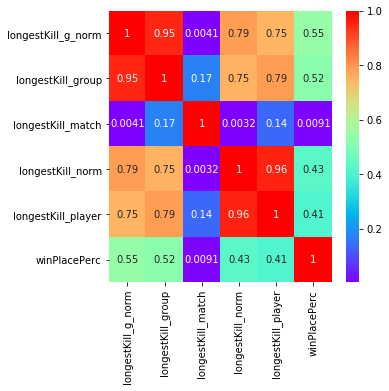

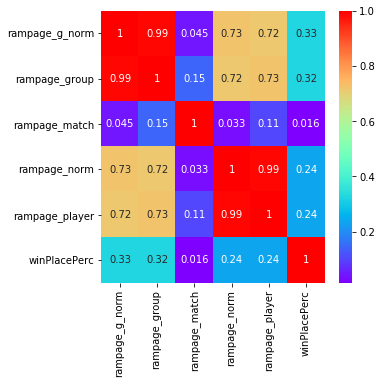

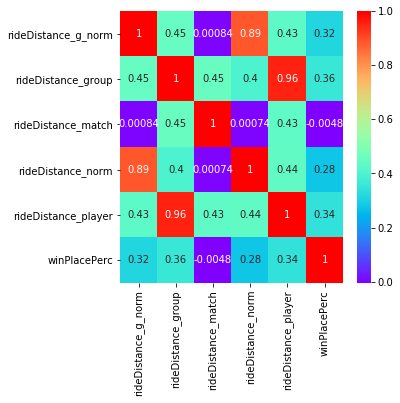

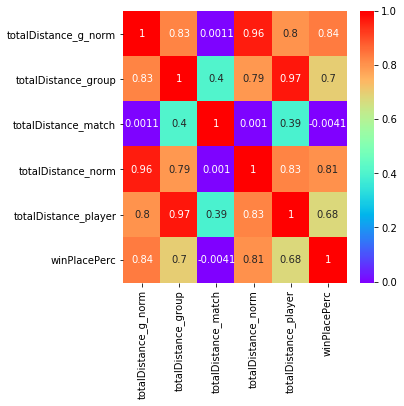

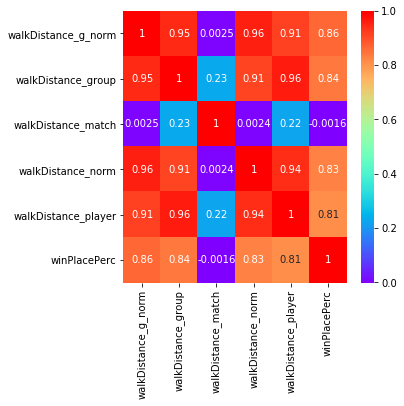

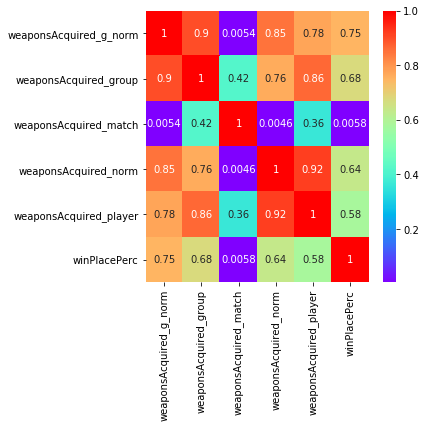

In [15]:
# now we can compare the correlation of different 
# versions of the variable quite easily

# grab our columns
available_columns = list(pubg_engineered.columns.values)
# work out where each group of variables we want to compare start
start_values = [0,7,17,22,27,32,37,42,47,59,64,73,78,83] 
# loop over our subsets creating correlation plots
for start in start_values:
    column_selection =  available_columns[
        start: start+5] + ['winPlacePerc']
    corr_vals = pubg_engineered[column_selection].corr()

    fig, axes = plt.subplots(figsize=(5,5))
    sns.heatmap(corr_vals, ax = axes, 
                cmap="rainbow", annot=True);